# A mouse's daily activity log {#sec-movement-mouse}

Before we start, make sure you have created the `animals-in-motion-env` environment (see [prerequisites @sec-install-movement]), and are using it to run this notebook.

Let's download some sample data from the `movement` package.

In [1]:
# | include: false

import xarray as xr

xr.set_options(
    display_expand_attrs=False,
    display_expand_coords=False,
    keep_attrs=True,
)

In [2]:
from movement import sample_data

from matplotlib import pyplot as plt

import pandas as pd

SHA256 hash of downloaded file: cf2876bab4f754d48d3c9f113ce5ac91787304cc587d33d8bf1124d5358e957f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


We will use the following 3 files:

- DLC_smart-kage3_datetime-20240417T090006.predictions.h5
- DLC_smart-kage3_datetime-20240417T100006.predictions.h5
- DLC_smart-kage3_datetime-20240417T110006.predictions.h5

Each file corresponds to a 1-hour segment of a video recording of a mouse in its home cage.
The start date and time of each file is indicated in the filename, in the format `YYYYMMDDTHHMMSS`.

In [3]:
filename_list = [
    "DLC_smart-kage3_datetime-20240417T090006.predictions.h5",
    "DLC_smart-kage3_datetime-20240417T100006.predictions.h5",
    "DLC_smart-kage3_datetime-20240417T110006.predictions.h5",
]

ds_list = []  # list of loaded datasets
for filename in filename_list:
    ds = sample_data.fetch_dataset(filename, with_video=True)
    ds_list.append(ds)

ds_list[0]

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 7161, space: 2, keypoints: 8, individuals: 1)
Coordinates: (4)
Data variables:
    position     (time, space, keypoints, individuals) float64 917kB 95.43 .....
    confidence   (time, keypoints, individuals) float64 458kB 0.2016 ... 0.00...
Attributes: (7)

Let's assign datetime timestamps to the dataset and concatenate them.

In [4]:
ds_list_datetime = []

for i, ds in enumerate(ds_list):
    start_datetime_str = filename_list[i].split(".")[0].split("-")[-1]
    print(f"Extracted datetime string: {start_datetime_str}")
    start_datetime = pd.Timestamp(start_datetime_str)
    print("Extracted start datetime: ", start_datetime)

    timestamps = pd.date_range(
        start=start_datetime,
        periods=ds.sizes["time"],
        freq=pd.Timedelta(seconds=1 / ds.attrs["fps"]),
    )

    ds_dt = ds.assign_coords(time=timestamps)
    ds_dt.attrs["time_unit"] = "datetime64[ns]"
    ds_list_datetime.append(ds_dt)

ds_list_datetime[0]

Extracted datetime string: 20240417T090006
Extracted start datetime:  2024-04-17 09:00:06
Extracted datetime string: 20240417T100006
Extracted start datetime:  2024-04-17 10:00:06
Extracted datetime string: 20240417T110006
Extracted start datetime:  2024-04-17 11:00:06


<xarray.Dataset> Size: 1MB
Dimensions:      (space: 2, keypoints: 8, individuals: 1, time: 7161)
Coordinates: (4)
Data variables:
    position     (time, space, keypoints, individuals) float64 917kB 95.43 .....
    confidence   (time, keypoints, individuals) float64 458kB 0.2016 ... 0.00...
Attributes: (7)

In [5]:
ds_all = xr.concat(ds_list_datetime, dim="time")
ds_all

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 21531, space: 2, keypoints: 8, individuals: 1)
Coordinates: (4)
Data variables:
    position     (time, space, keypoints, individuals) float64 3MB 95.43 ... ...
    confidence   (time, keypoints, individuals) float64 1MB 0.2016 ... 1.0
Attributes: (7)

Let's see how reliable this data is.

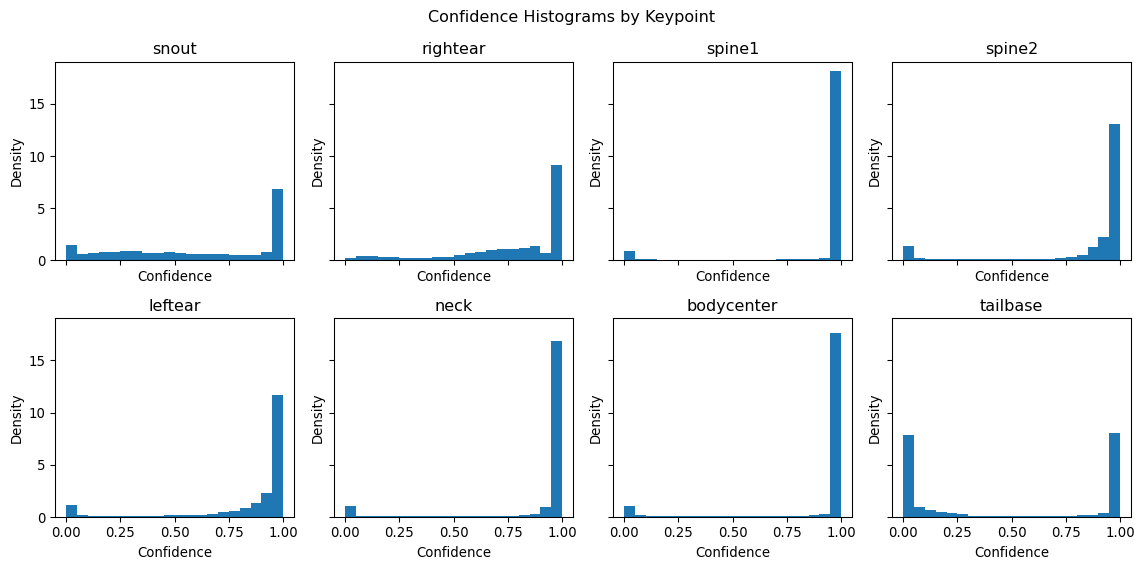

In [6]:
# | echo: false

from pathlib import Path


def plot_confidence_hist_by_keypoint(
    ds: xr.Dataset,
    save_path: Path | None = None,
) -> None:
    """
    Plot histograms of confidence values for each keypoint in the dataset.

    Parameters
    ----------
    ds : xr.Dataset
        The dataset containing keypoint positions and confidence values.
    save_path : Path | None
        Optional path to save the plot. If None, the plot will not be saved.
    """
    n_keypoints = ds.sizes["keypoints"]

    # Create subplots for each keypoint
    fig, axes = plt.subplots(
        nrows=2,
        ncols=(n_keypoints + 1) // 2,
        figsize=(n_keypoints * 1.5, n_keypoints * 0.75),
        sharey=True,
        sharex=True,
    )

    # Loop through each keypoint and plot its confidence histogram
    for i, kpt in enumerate(ds.keypoints.values):
        ax = axes[i % 2, i // 2]
        ds.confidence.sel(keypoints=kpt).plot.hist(
            bins=20,
            ax=ax,
            label=kpt,
            histtype="stepfilled",
            density=True,
        )
        ax.set_ylabel("Density")
        ax.set_xlabel("")
        ax.set_xlabel("Confidence")
        ax.set_title(kpt)

    plt.suptitle("Confidence Histograms by Keypoint")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=128)


plot_confidence_hist_by_keypoint(ds_all)

We'll use the "bodycenter" keypoint to track the mouse's movement, as it's quite reliable.

In [7]:
bodycenter = ds_all.sel(
    individuals="individual_0",  # the only one, in this case
    keypoints="bodycenter",  # select the desired keypoint
).position  # extract the "position" variable

bodycenter

<xarray.DataArray 'position' (time: 21531, space: 2)> Size: 344kB
94.54 150.5 97.52 148.0 97.52 147.3 ... 386.3 96.47 386.4 96.01 385.9 96.84
Coordinates: (4)